# Predictive Models: Iterration 2

In [1]:
#import libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data from Week 2
df = pd.read_csv('US_Accidents_June20_CLEAN_Week2_Iteration2.0.csv')
print('df.shape:', df.shape)

df.shape: (2443292, 161)


In [3]:
#Display features
df.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Amenity', 'Bump',
       ...
       'Wind_Direction_SE', 'Wind_Direction_SSE', 'Wind_Direction_SSW',
       'Wind_Direction_SW', 'Wind_Direction_VAR', 'Wind_Direction_W',
       'Wind_Direction_WNW', 'Wind_Direction_WSW', 'Sunrise_Sunset_Day',
       'Sunrise_Sunset_Night'],
      dtype='object', length=161)

Models and performance indicators:<br>
* Since the predicted values can be 1,2,3 or 4, I'll tackle the problem as a multiclass classification problem. For that reason, I'll first define a baseline prediction performance with a <b>linear SVM</b>.
* Next, other models will be assessed: <b>Decision Trees</b>, <b>Random Forest</b> and a simple <b>Fully Connected Deep Neural Network</b>.
* In order to assess the performance of the different models, the accuracy of the model will be regarded and the cofusion matrix for each model will be inspected.
* Additionally, the Feature Importance of each model will be displayed for better model understanding.

# Sample to deal with class imbalance

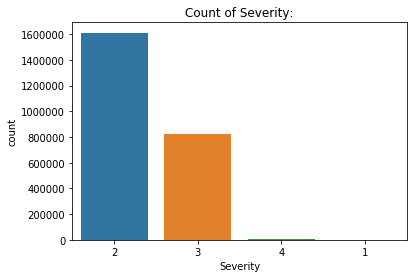

In [4]:
# plot severity of data to see how imbalance the data is

fig, ax = plt.subplots()
sns.countplot('Severity',data=df,ax=ax,order=df['Severity'].value_counts().index)
ax.set_title('Count of Severity:')
plt.show()

There is a big class imbalance. In order to deal with it, I'll undersample classes 2, 3 and 4 and oversample class 1.

In [5]:
for i in range (4):
    print('Severity level {}:'.format(i+1), df.loc[df['Severity']==i+1].shape[0])

Severity level 1: 1052
Severity level 2: 1611005
Severity level 3: 824594
Severity level 4: 6641


There is very few data with severity 1 and 4. This was expected since almost all Severity 1 and 4 data came from the <b>Bing</b> data set. I think oversampling to 50000 is too much. I'll try with just 5000 datpoints and let's see how the performance is impacted.

In [6]:
#define random state for replicability
my_random_state = 4
#take 50000 datapoints of each severity in order for the data to be balanced.
df_sampled = pd.concat([df[df['Severity']==1].sample(5000, replace = True, random_state=my_random_state),
                        df[df['Severity']==2].sample(5000, random_state=my_random_state),
                        df[df['Severity']==3].sample(5000, random_state=my_random_state),
                       df[df['Severity']==4].sample(5000, random_state=my_random_state)],
                       axis=0)
df_sampled

,Severity,Start_Lat,Start_Lng,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Amenity,Bump,...,Wind_Direction_SE,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Sunrise_Sunset_Day,Sunrise_Sunset_Night
229429,1,39.971527,-76.713028,19.0,46.0,30.02,10.0,24.2,False,False,...,0,0,0,0,0,0,1,0,1,0
643435,1,37.891888,-121.641418,48.0,86.0,29.68,5.0,6.0,False,False,...,0,0,0,0,0,0,0,0,1,0
1508208,1,32.103958,-110.772774,72.9,13.0,29.92,10.0,7.0,False,False,...,0,0,0,0,0,0,0,0,1,0
464777,1,33.960579,-84.411613,77.0,78.0,29.77,10.0,4.6,False,False,...,0,0,0,0,0,0,0,0,1,0
666346,1,39.764111,-75.139160,48.0,66.0,30.22,10.0,12.0,False,False,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101874,4,45.524277,-122.686539,58.0,72.0,30.09,10.0,6.0,False,False,...,0,0,0,0,0,0,0,0,1,0
126716,4,25.789072,-80.204353,69.1,58.0,29.97,10.0,5.8,False,False,...,0,0,0,0,0,0,0,0,0,1
921671,4,25.861931,-80.208611,91.0,55.0,29.93,10.0,15.0,False,False,...,0,0,0,0,0,0,0,0,1,0
1284701,4,33.463760,-86.824303,64.0,78.0,30.00,2.5,13.8,False,False,...,0,0,0,0,0,0,1,0,1,0


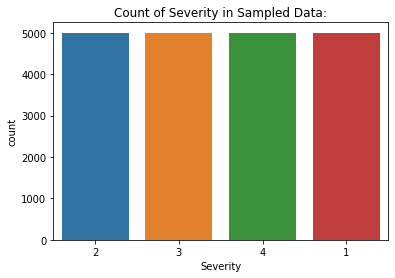

In [7]:
#Plot sampled data

fig, ax = plt.subplots()
sns.countplot('Severity',data=df_sampled,ax=ax,order=df['Severity'].value_counts().index)
ax.set_title('Count of Severity in Sampled Data:')
plt.show()

# Train Test Split

In [8]:
# split X, y
X = df_sampled.drop('Severity', axis=1)
y = df_sampled['Severity']

# Standardizing the features based on unit variance

X = StandardScaler().fit_transform(X)

# split train test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=my_random_state) #my_random_state is defined in the cell above!

# Algorithms

In [9]:
#First look the number of datapoints in order to define the maximum iterations that will be allowed

n_datapoints = df_sampled.shape[0]
df_sampled.shape

(20000, 161)

## Linear Support Vector Machine (Baseline performance)

In [10]:
# Support Vector Machine

lin_clf = svm.LinearSVC(verbose=2)
lin_clf.fit(X_train, y_train)

[LibLinear]

/Users/pedro.roig.aparicio@ibm.com/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=2)

In [11]:
#Print Accuracy of the model
print('Linear SVM Accuracy:')
print('*'*20)
accuracy_train_lin = lin_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (accuracy_train_lin*100))
accuracy_test_lin = lin_clf.score(X_test, y_test)
print("Test Accuracy: %.1f%%"% (accuracy_test_lin*100))

Linear SVM Accuracy:
********************
Train Accuracy: 60.5%
Test Accuracy: 61.7%


array([[[1937,  301],
        [ 267,  495]]])

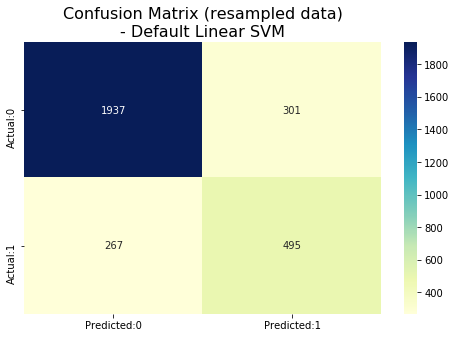

In [12]:
y_pred = lin_clf.predict(X_test)

confmat = multilabel_confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1])
display(confmat)

conf_matrix = pd.DataFrame(data=confmat[0], columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d',cmap="YlGnBu").set_title("Confusion Matrix (resampled data)\n- Default Linear SVM", fontsize=16)
plt.show()

The accuracy achieved by the baseline model is less than for iteration 1. Let's see how the other models perform.

## Decision Tree

Now I'll try out a Decision Tree.

In [13]:
DT_grid = { 'min_samples_split': [10,20,30,40,50],'max_features': [None, 'log2', 'sqrt']}

CV_DT = GridSearchCV(DecisionTreeClassifier(random_state=my_random_state), DT_grid, verbose=2, cv=3) #my_random_state is defined in a cell above!

CV_DT.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] max_features=None, min_samples_split=10 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... max_features=None, min_samples_split=10, total=   0.3s
[CV] max_features=None, min_samples_split=10 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......... max_features=None, min_samples_split=10, total=   0.3s
[CV] max_features=None, min_samples_split=10 .........................
[CV] .......... max_features=None, min_samples_split=10, total=   0.3s
[CV] max_features=None, min_samples_split=20 .........................
[CV] .......... max_features=None, min_samples_split=20, total=   0.3s
[CV] max_features=None, min_samples_split=20 .........................
[CV] .......... max_features=None, min_samples_split=20, total=   0.4s
[CV] max_features=None, min_samples_split=20 .........................
[CV] .......... max_features=None, min_samples_split=20, total=   0.4s
[CV] max_features=None, min_samples_split=30 .........................
[CV] .......... max_features=None, min_samples_split=30, total=   0.4s
[CV] max_features=None, min_samples_split=30 .........................
[CV] .......... max_features=None, min_samples_split=30, total=   0.3s
[CV] max_features=None, min_samples_split=30 .........................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.8s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=4, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_split': [10, 20, 30, 40,

In [14]:
print('Best Parameters: ', CV_DT.best_params_)

Best Parameters:  {'max_features': None, 'min_samples_split': 10}


In [15]:
#Use best parameters to check Test Accuracy
tree_clf = DecisionTreeClassifier(min_samples_split = CV_DT.best_params_['min_samples_split'])
tree_clf = tree_clf.fit(X_train,y_train)

#Print Train and Test Accuracy
tree_accuracy_train = tree_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (tree_accuracy_train*100))
tree_accuracy_test = tree_clf.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (tree_accuracy_test*100))

Train Accuracy: 91.9%
Test Accuracy: 69.4%


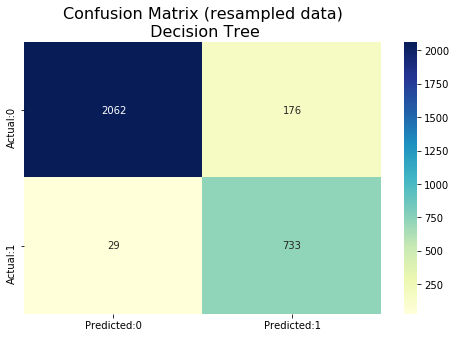

In [16]:
# Confusion Matrix
prediction = tree_clf.predict(X_test)

confmat = multilabel_confusion_matrix(y_true=y_test, y_pred=prediction)

conf_matrix = pd.DataFrame(data=confmat[0],columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title("Confusion Matrix (resampled data)\n Decision Tree", fontsize=16)
plt.show()

The overfit of the Decision Tree is even bigger than for iteration 1. Of course having less data it is more difficult to generalize to the test dataset.

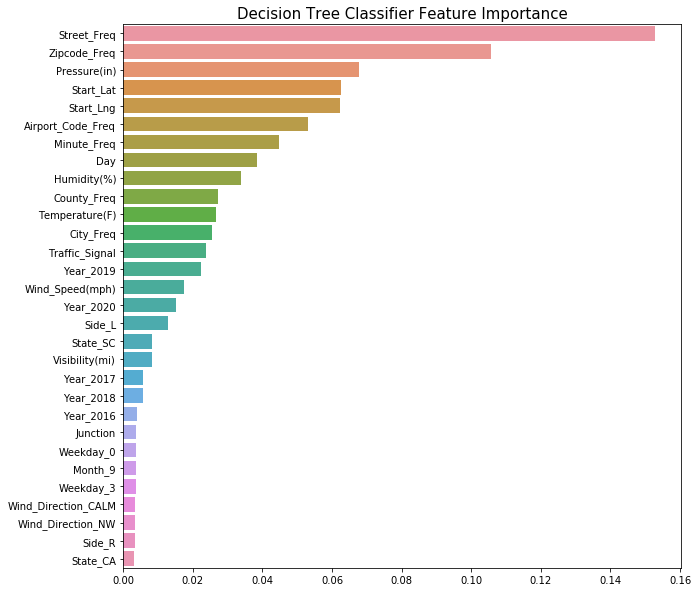

In [17]:
#Feature importance

importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=['importance'], index=df.drop('Severity',axis=1).columns)

importances.iloc[:,0] = tree_clf.feature_importances_

importances.sort_values(by='importance', inplace=True, ascending=False)
importances30 = importances.head(30)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y=importances30.index, data=importances30)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Decision Tree Classifier Feature Importance', size=15)

plt.show()

At least now the Feature Importance makes more sense. The one-hot enconding of Year_2020 is out of the top features! These are good news!

## Random Forest

During this iteration I'll be able to look into more parameters during the cross-validation, since the amount of data fed to the model is 10 times less than in iteration 1.

In [19]:
param_grid = { 
    'n_estimators'     : [5,10,20,30,40,50],
    'max_depth'        : [5,10,20,30,40,50]
}
CV_clf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid,cv=4,verbose=2)
CV_clf.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV] max_depth=5, n_estimators=5 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... max_depth=5, n_estimators=5, total=   0.4s
[CV] max_depth=5, n_estimators=5 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...................... max_depth=5, n_estimators=5, total=   0.4s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.4s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.3s
[CV] max_depth=5, n_estimators=10 ....................................
[CV] ..................... max_depth=5, n_estimators=10, total=   0.7s
[CV] max_depth=5, n_estimators=10 ....................................
[CV] ..................... max_depth=5, n_estimators=10, total=   0.7s
[CV] max_depth=5, n_estimators=10 ....................................
[CV] ..................... max_depth=5, n_estimators=10, total=   0.7s
[CV] max_depth=5, n_estimators=10 ....................................
[CV] ..................... max_depth=5, n_estimators=10, total=   0.7s
[CV] max_depth=5, n_estimators=20 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  9.8min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [20]:
print('Best Parameters: ', CV_clf.best_params_)

Best Parameters:  {'max_depth': 50, 'n_estimators': 50}


In [21]:
rf_clf = RandomForestRegressor(max_depth=CV_clf.best_params_['max_depth'],n_estimators=CV_clf.best_params_['n_estimators'])
rf_clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [22]:
rf_accuracy_train = rf_clf.score(X_train, y_train)
print("Train Accuracy: %.1f%%"% (rf_accuracy_train*100))
rf_accuracy_test = rf_clf.score(X_test,y_test)
print("Test Accuracy: %.1f%%"% (rf_accuracy_test*100))

Train Accuracy: 96.9%
Test Accuracy: 78.7%


The performance of the Random Forest is better than in the first iteration, with also a big overfit. We should notice that even though the data amount used is 10 times less than in the first iteration, the performance is only slightly worse, so the current data preprocessing and <b>Feature Engineering</b> is dealing good results. 

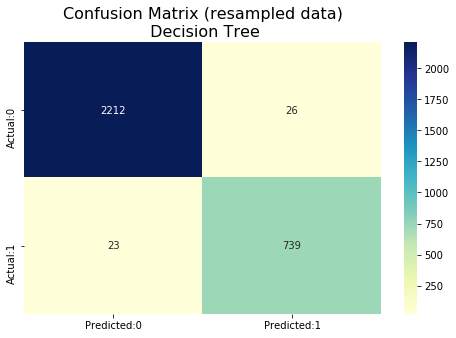

In [23]:
# Confusion Matrix
prediction = np.round(rf_clf.predict(X_test))

confmat = multilabel_confusion_matrix(y_true=y_test, y_pred=prediction)

conf_matrix = pd.DataFrame(data=confmat[0],columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title("Confusion Matrix (resampled data)\n Decision Tree", fontsize=16)
plt.show()

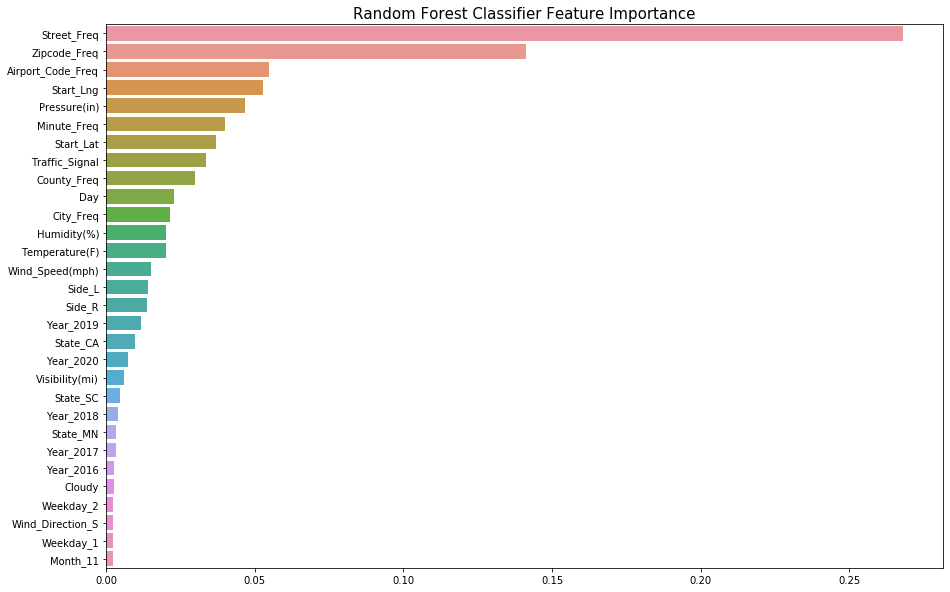

In [24]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=['importance'], index=df.drop('Severity',axis=1).columns)

importances.iloc[:,0] = rf_clf.feature_importances_

importances.sort_values(by='importance', inplace=True, ascending=False)
importances30 = importances.head(30)

plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y=importances30.index, data=importances30)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Random Forest Classifier Feature Importance', size=15)

plt.show()

Again, this Features make much more sense than during iteration 1.

## Neural Network

For the NN to work, I need to first one-hot encode the y-labels!

In [25]:
# One-hot encode the 4 severity levels!
y_train_encoded = pd.get_dummies(y_train, drop_first=False)
y_test_encoded = pd.get_dummies(y_test, drop_first=False)

Since I am dealing with 10 times fewer data, I need a more simple model in order to not overfit.

In [50]:
# Define the keras model

model = Sequential()
model.add(Dense(50, input_dim=160, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [51]:
# Compile the keras model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
# Fit the keras model on the dataset

model.fit(X_train, y_train_encoded, epochs=30, batch_size=32)

Epoch 1/30
532/532 [==============================] - 0s 737us/step - loss: 1.0712 - accuracy: 0.5311
Epoch 2/30
532/532 [==============================] - 0s 742us/step - loss: 0.8815 - accuracy: 0.6319
Epoch 3/30
532/532 [==============================] - 0s 852us/step - loss: 0.8091 - accuracy: 0.6738
Epoch 4/30
532/532 [==============================] - 0s 823us/step - loss: 0.7494 - accuracy: 0.7050
Epoch 5/30
532/532 [==============================] - 0s 775us/step - loss: 0.6964 - accuracy: 0.7258
Epoch 6/30
532/532 [==============================] - 0s 810us/step - loss: 0.6535 - accuracy: 0.7446
Epoch 7/30
532/532 [==============================] - 0s 787us/step - loss: 0.6190 - accuracy: 0.7639
Epoch 8/30
532/532 [==============================] - 0s 759us/step - loss: 0.5869 - accuracy: 0.7724
Epoch 9/30
532/532 [==============================] - 0s 802us/step - loss: 0.5613 - accuracy: 0.7828
Epoch 10/30
532/532 [==============================] - 0s 772us/step - loss: 0.538

In [53]:
# Evaluate the keras model

_, accuracy_nn_train = model.evaluate(X_train, y_train_encoded)
print('Accuracy: %.2f' % (accuracy_nn_train*100))

_, accuracy_nn_test = model.evaluate(X_test, y_test_encoded)
print('Accuracy: %.2f' % (accuracy_nn_test*100))

532/532 [==============================] - 0s 543us/step - loss: 0.2954 - accuracy: 0.8869
Accuracy: 88.69
94/94 [==============================] - 0s 641us/step - loss: 1.0164 - accuracy: 0.7020
Accuracy: 70.20


The DL approach is doing slightly better as in the same interation, but more or less as good. Also here it should be noticed that there was 10 times fewer data and (also because of the fewer data fed to the model) a lot less training time.

## Summary table

In [56]:
df_summary = pd.DataFrame(columns=['Model', 'Train_Accuracy[%]', 'Test_Accuracy[%]'])

In [57]:
df_summary.Model = ['Linear SVM', 'Decision Tree', 'Random Forest', 'Neural Network']
df_summary['Train_Accuracy[%]'] = ['60.5', '91.9', '96.9', '88.69']
df_summary['Test_Accuracy[%]'] = ['61.7', '69.4', '78.7', '70.2']

In [58]:
df_summary

,Model,Train_Accuracy[%],Test_Accuracy[%]
0,Linear SVM,60.5,61.7
1,Decision Tree,91.9,69.4
2,Random Forest,96.9,78.7
3,Neural Network,88.69,70.2


## Conclusions and Outlook

Iteration 2 was quite successful. With 10 times fewer data and much less training time for all algorithms I acheived a higher model accuracy than in the first iteration. Even though the model.<br>

It was a pitty that so much data was lost due to dropping the data from 'Source' <b>Bing</b>. A future work could study if the performance can be notably enhanced by only categorizing between severity levels 2-4, since the data available for those categories is around 6 times more so it would be interesting to see how the model performs with such an amount of data.